In [1]:
import torch
from numpy import loadtxt,sqrt,ceil,floor
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from basis import KL,logprob_gamma
import nf_class
import pandas as pd


In [2]:

def prob_nf(xb,filename,N,met='sum'):
    if met == 'sum':
        model = nf_class.Deconvolver(x,a_distribution)
    if met == 'prod':
        model = nf_class.ProdDeconvolver(x,a_distribution)
    model.load_state_dict(torch.load('models/'+met+'_nf_'+filename.split('.')[0]+'datapoints_{}.pt'.format(N)))
    p_nf = model.get_pdf(xb)[1]
    return p_nf.to(xb.device)

def prob_bayes(xb,filename,N,met='sum'):
    if met == 'sum':
        shape,scale,lps =  torch.tensor(pd.read_csv('models/sum_bayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:].T)
    if met == 'prod':
        shape,scale,lps =  torch.tensor(pd.read_csv('models/prod_bayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:].T)

    i = torch.argmax(lps)
    p_map = torch.exp(logprob_gamma(xb,shape[i],scale[i]))

    logp = torch.logsumexp(torch.vstack([logprob_gamma(xb,sh,sc) for (sh,sc) in zip(shape,scale)]),axis=0)-torch.log(torch.tensor(len(lps)))#.to(device)
    p = torch.exp(logp)

    return p_map,p

logprob_gaussian = lambda x,mu,sig: -(((x-mu)/sig)**2)/2 - torch.log(sig) - 0.9189385175704956

def prob_npbayes(xb,filename,N,Ncomp=20,burn=5000,met='sum'):
    logprob_mixgaussian = lambda x,mus,sigs,rhos:torch.logsumexp(logprob_gaussian(x,mus.reshape(-1,1),sigs.reshape(-1,1))+torch.log(rhos.reshape(-1,1)),axis=0)
    
    if met == 'sum':
        logprob = logprob_mixgaussian
        g = pd.read_csv('models/sum_NPbayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:]
    elif met== 'prod':
        logprob_mixlognormal = lambda x,mus,sigs,rhos: logprob_mixgaussian(torch.log(x),mus,sigs,rhos)-torch.log(x)
        logprob = logprob_mixlognormal
        g = pd.read_csv('models/prod_NPbayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:]
        
    thetas,lps = torch.tensor(g[burn:,:-1]),torch.tensor(g[burn:,-1])

    i = torch.argmax(lps)
    th_map = thetas[i]
    p_map = torch.exp(logprob(xb,th_map[:Ncomp],th_map[Ncomp:2*Ncomp],th_map[2*Ncomp:]))

    logp = torch.logsumexp(torch.vstack([logprob(xb,th[:Ncomp],th[Ncomp:2*Ncomp],th[2*Ncomp:]) for th in thetas]),axis=0)-torch.log(torch.tensor(len(lps)))#.to(device)
    p = torch.exp(logp)

    return p_map,p
    
dfcolumns=['filename','method','N','KL_MAP','KL_reconstruct']    
def df_line(filename,met,N,xb,p_gt,p_map,p_rec=None):
    kl_map = KL(p_gt,p_map,xb).item()
    if p_rec is None:
        kl_rec = kl_map
    else:
        kl_rec = KL(p_gt,p_rec,xb).item()
    return pd.DataFrame ([[filename,met,N,kl_map,kl_rec]], columns=dfcolumns)

plot_cols = ['Data', 'Bayesian with known model', 'Bayesian with Gaussian mixture', 'NFdeconvolve']
def make_graph(ax,x,xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec,legend=True):
    ax[0].hist(x,density=True)
    ax[0].set_ylabel('N={}'.format(x.size(0)))

    [axi.plot(xb,p_gt,color='k',label='Ground Truth') for axi in ax[1:]]

    ax[1].plot(xb,bayes_map,label='MAP')
    ax[1].plot(xb,bayes_rec,label='Reconstruction')

    ax[2].plot(xb,npbayes_map,label='MAP')
    ax[2].plot(xb,npbayes_rec,label='Reconstruction')

    ax[3].plot(xb,p_nf,color='r',label='NFdeconvolve')

    if legend:
        [axi.legend() for axi in ax[1:]]
    [axi.set_ylim(0,torch.max(torch.stack((p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec)).nan_to_num(0)).item()*1.1) for axi in ax[1:] ]
    
    #[(axi.yaxis.set_major_formatter(ScalarFormatter(useMathText=True)), axi.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))) for axi in ax]
    

Ns = [100,316,1000,3160,10000]

/tmp/ipykernel_129917/4256316287.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/'+met+'_nf_'+filename.split('.')[0]+'datapoints

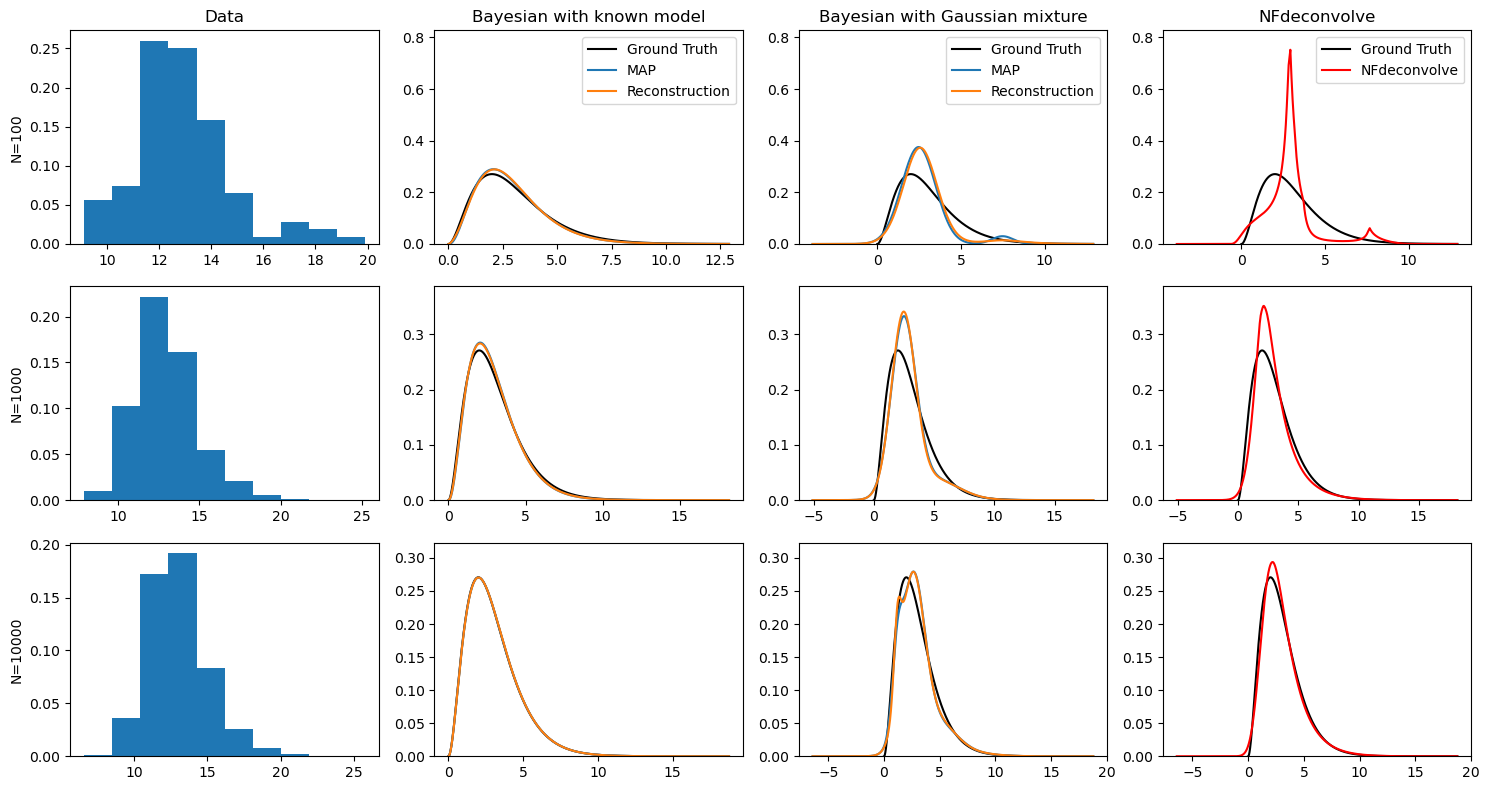

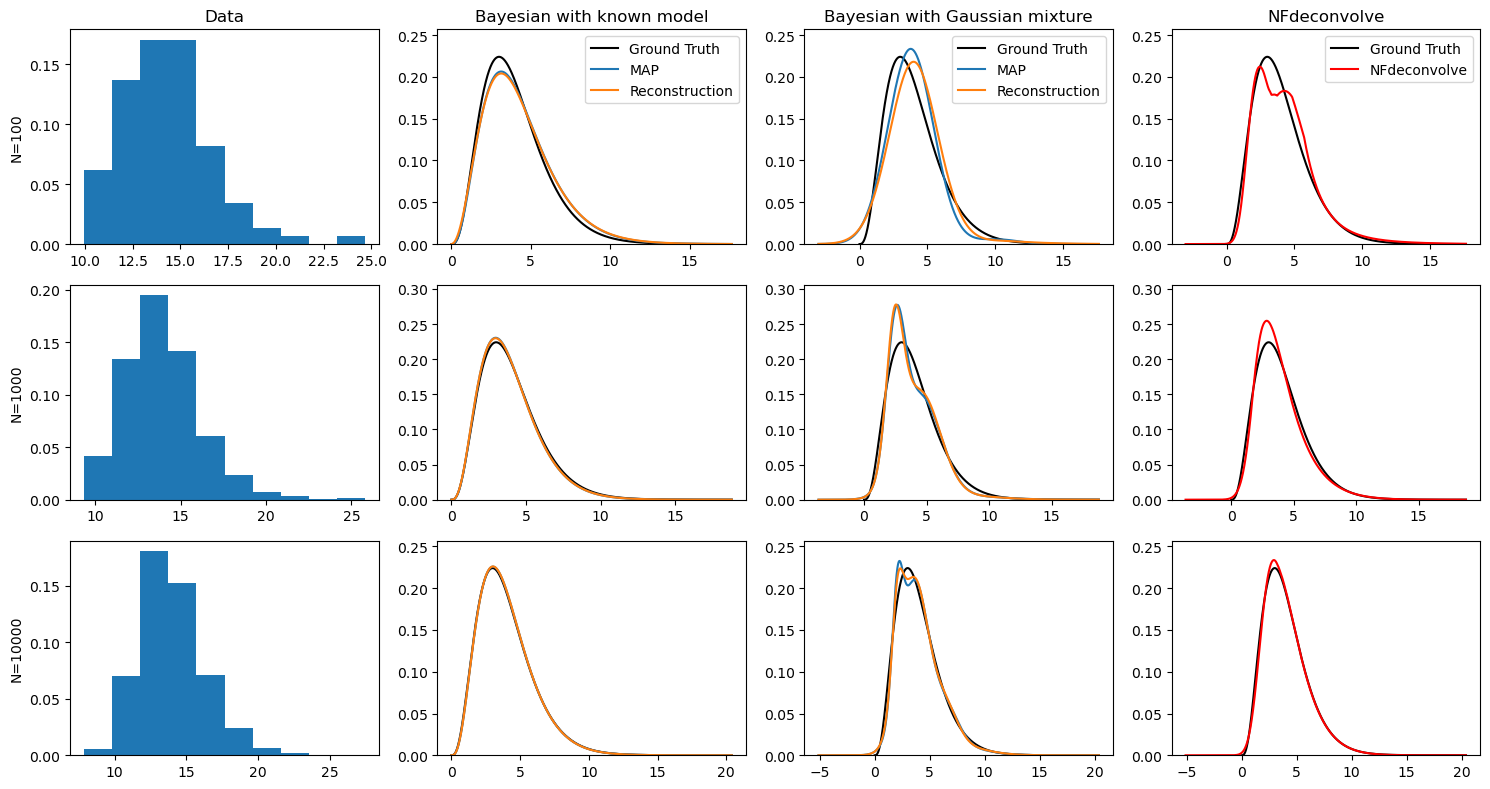

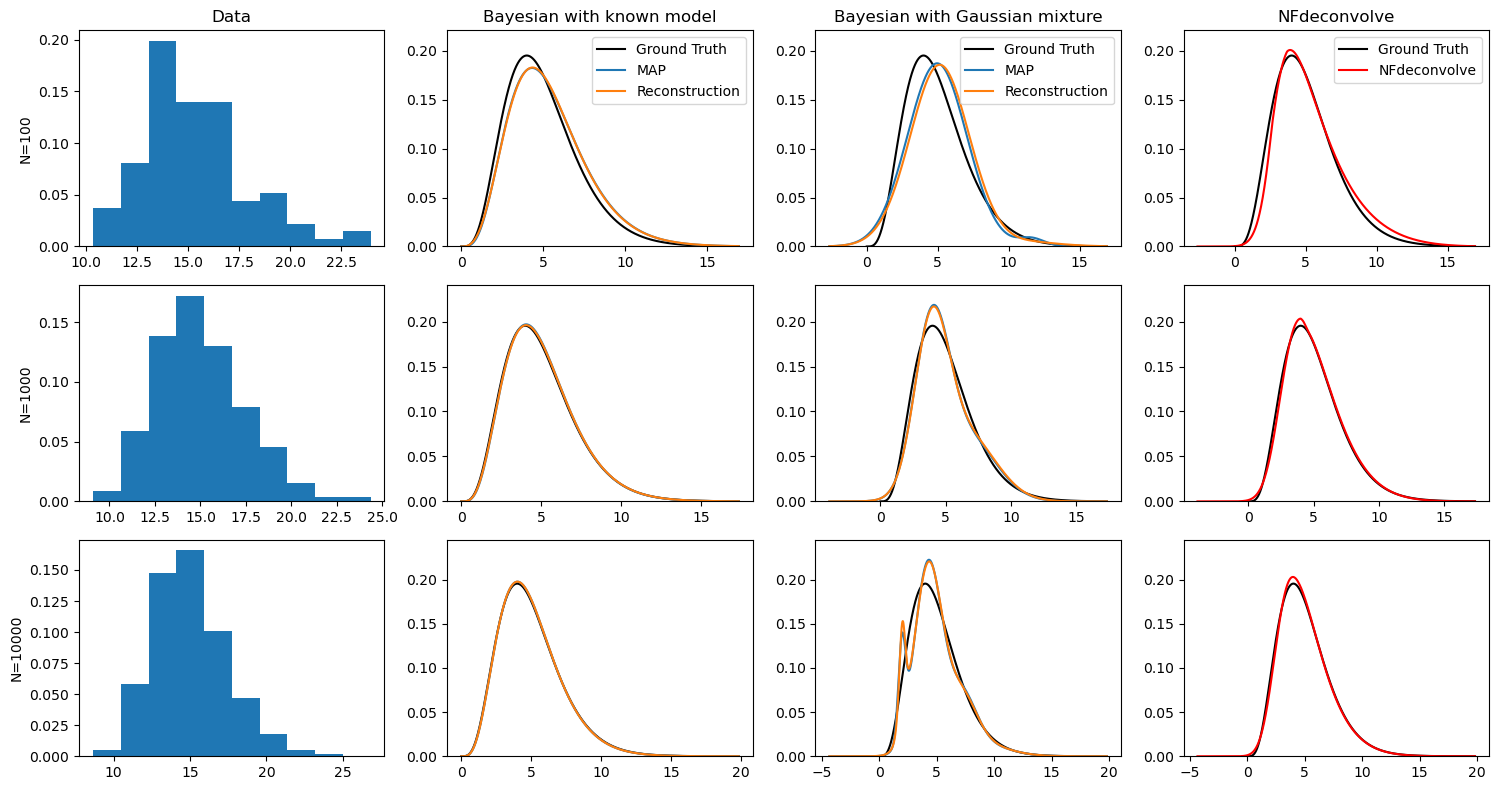

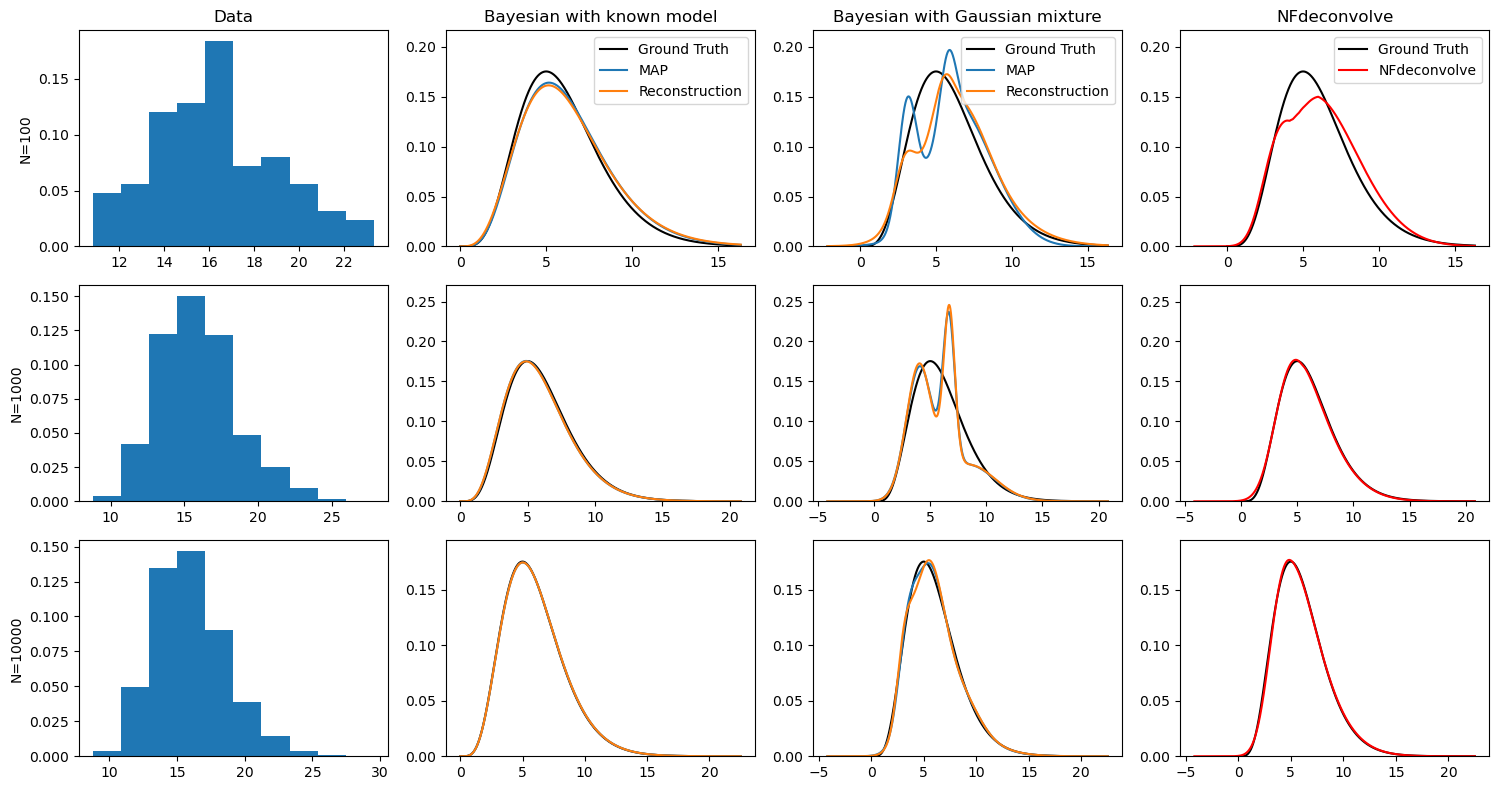

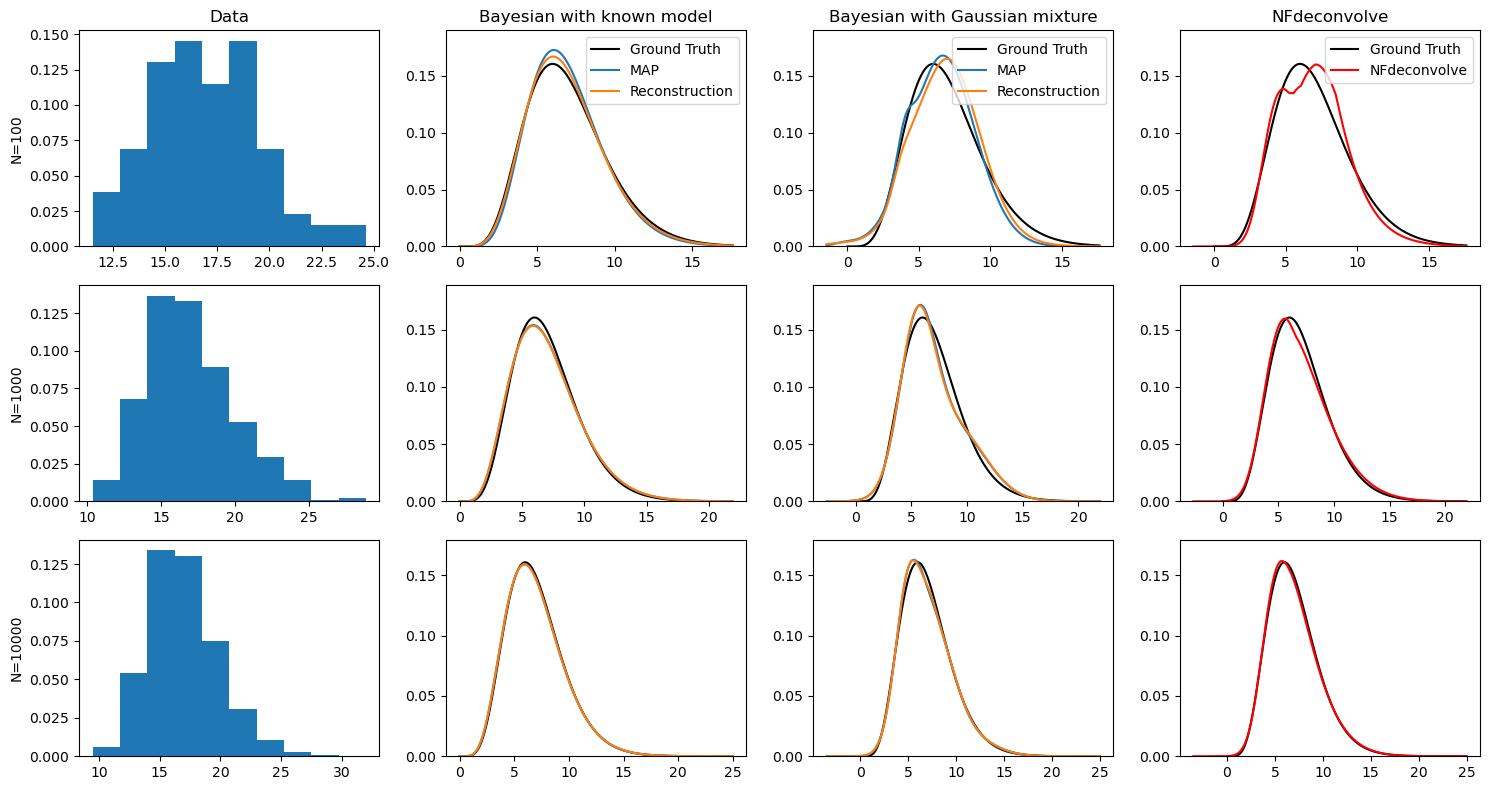

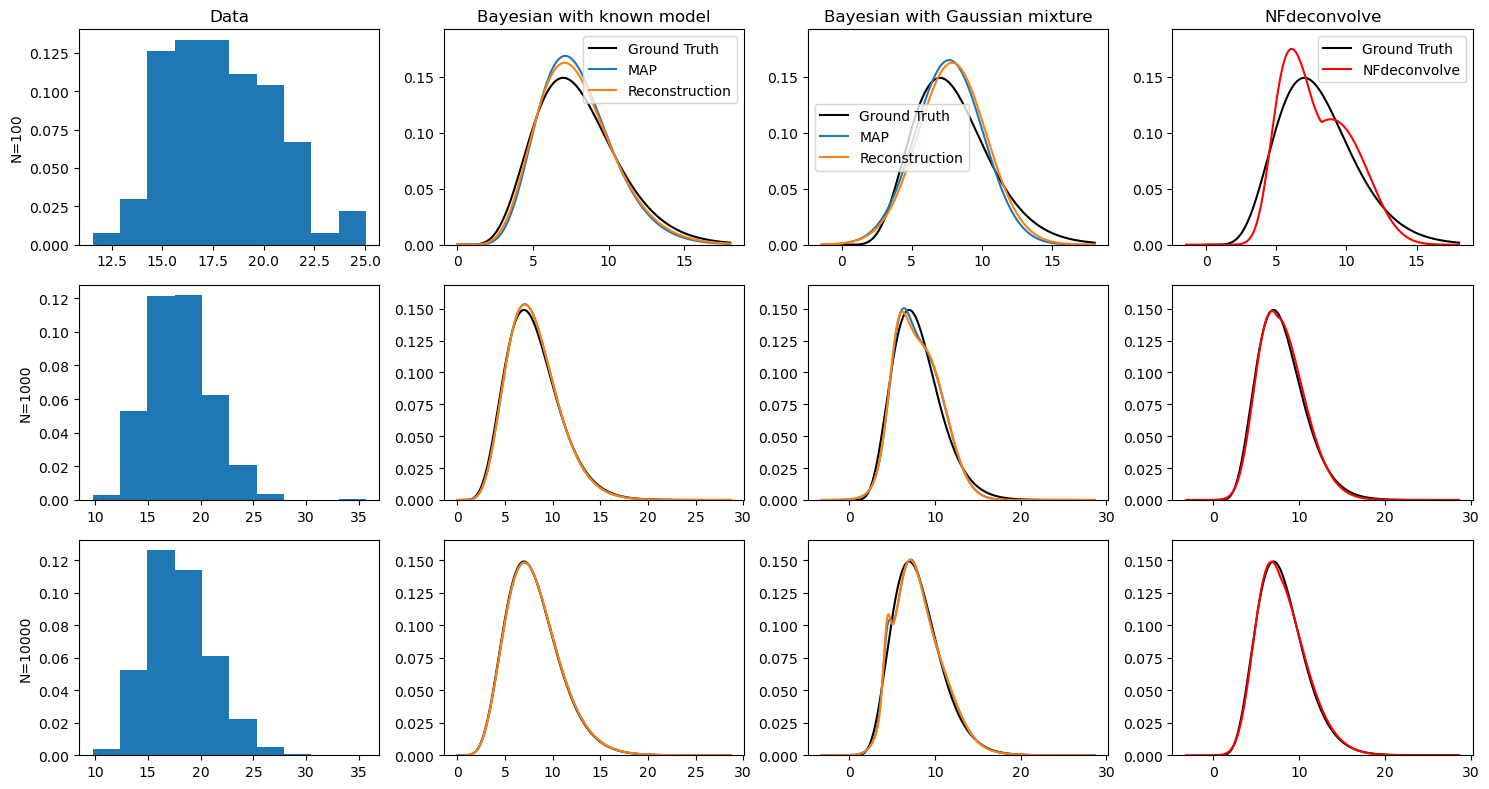

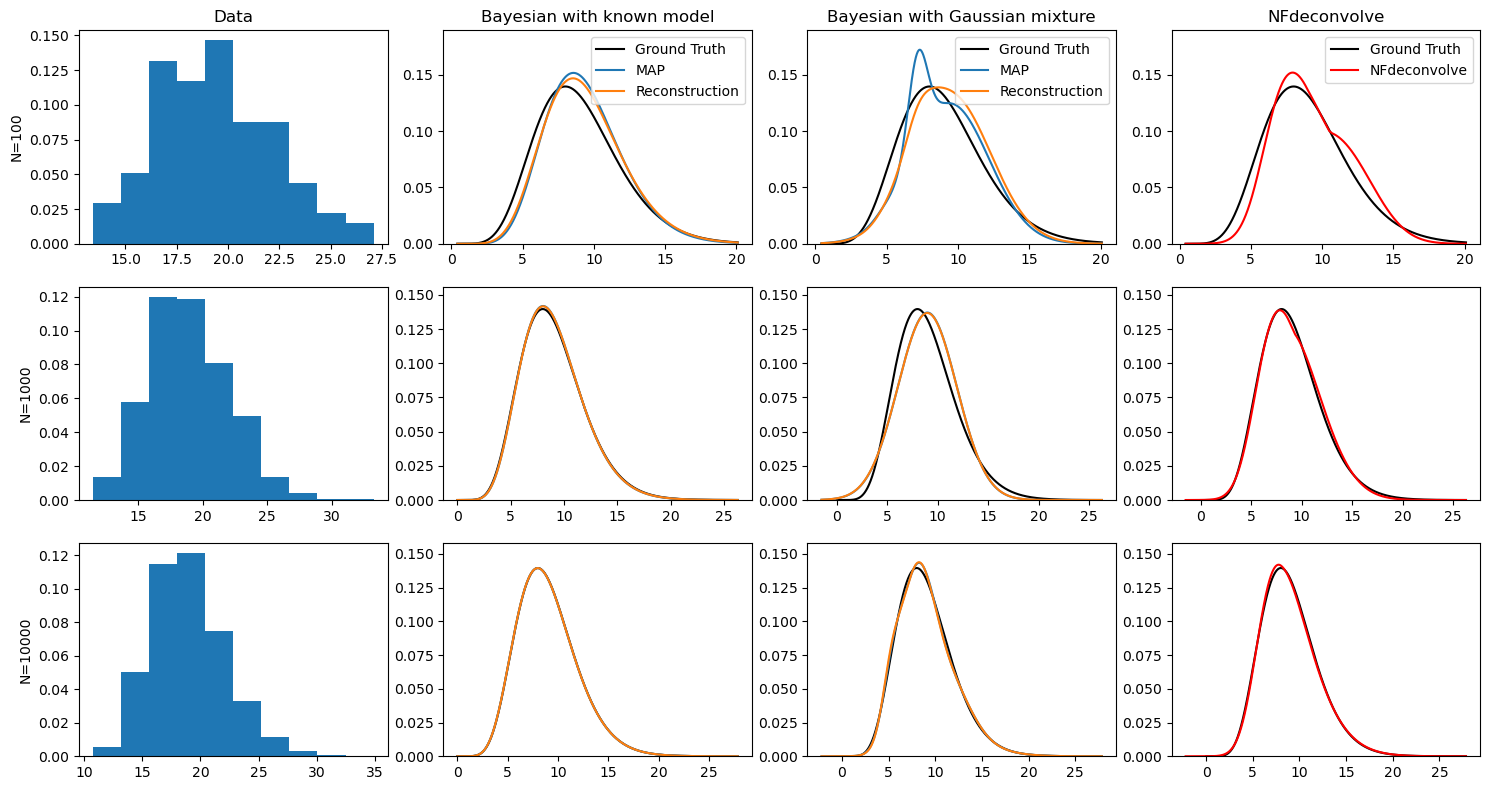

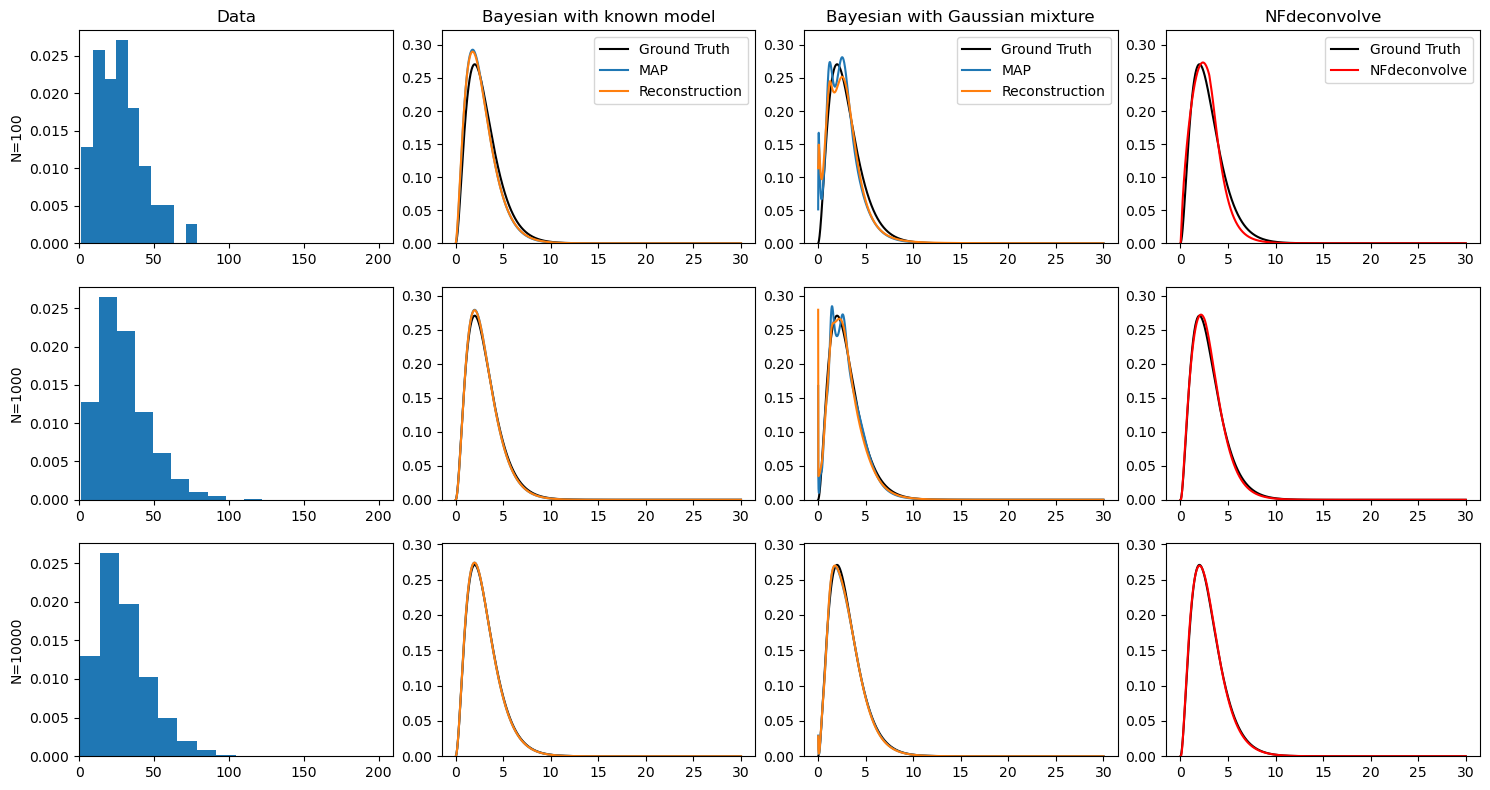

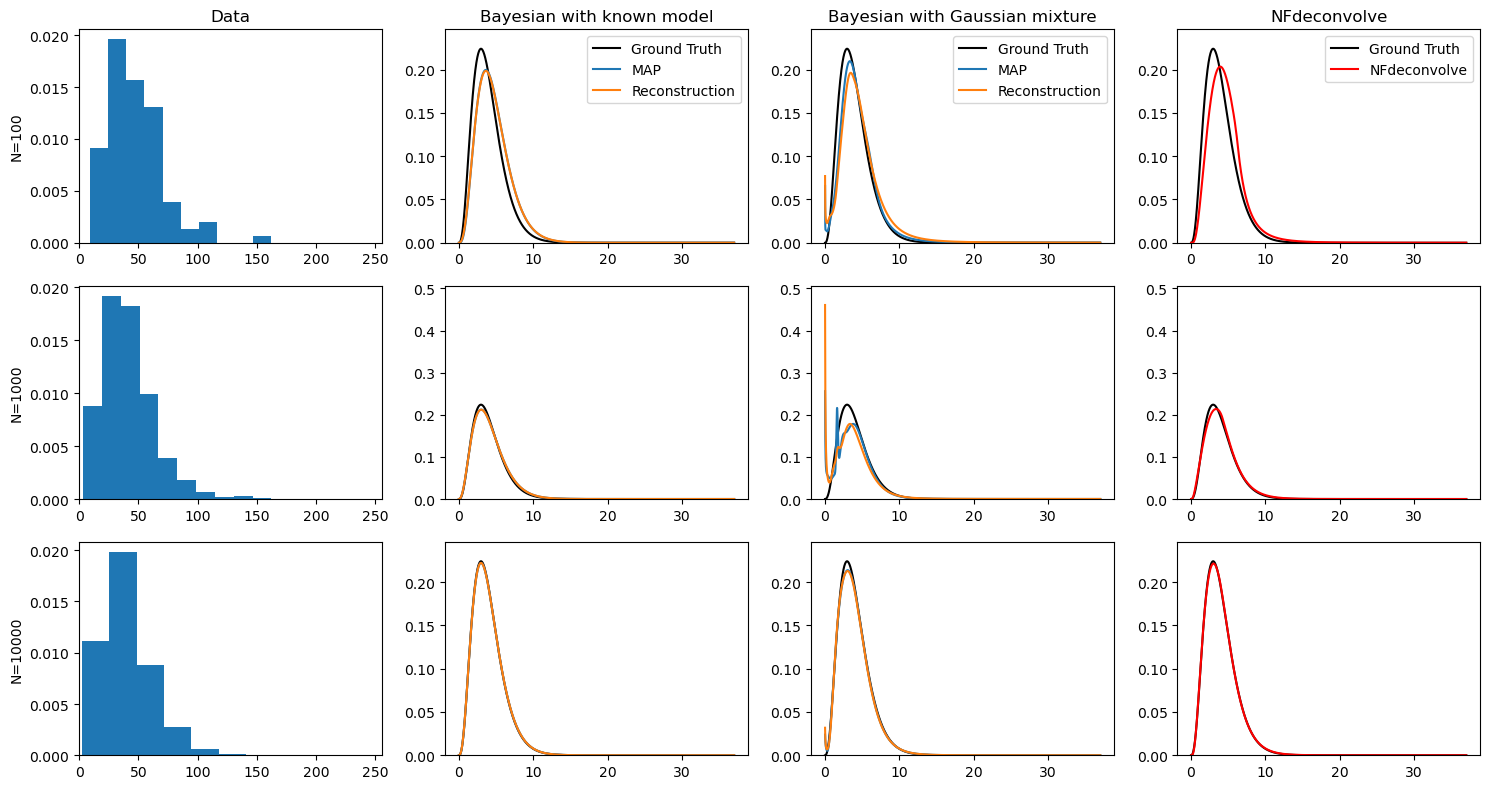

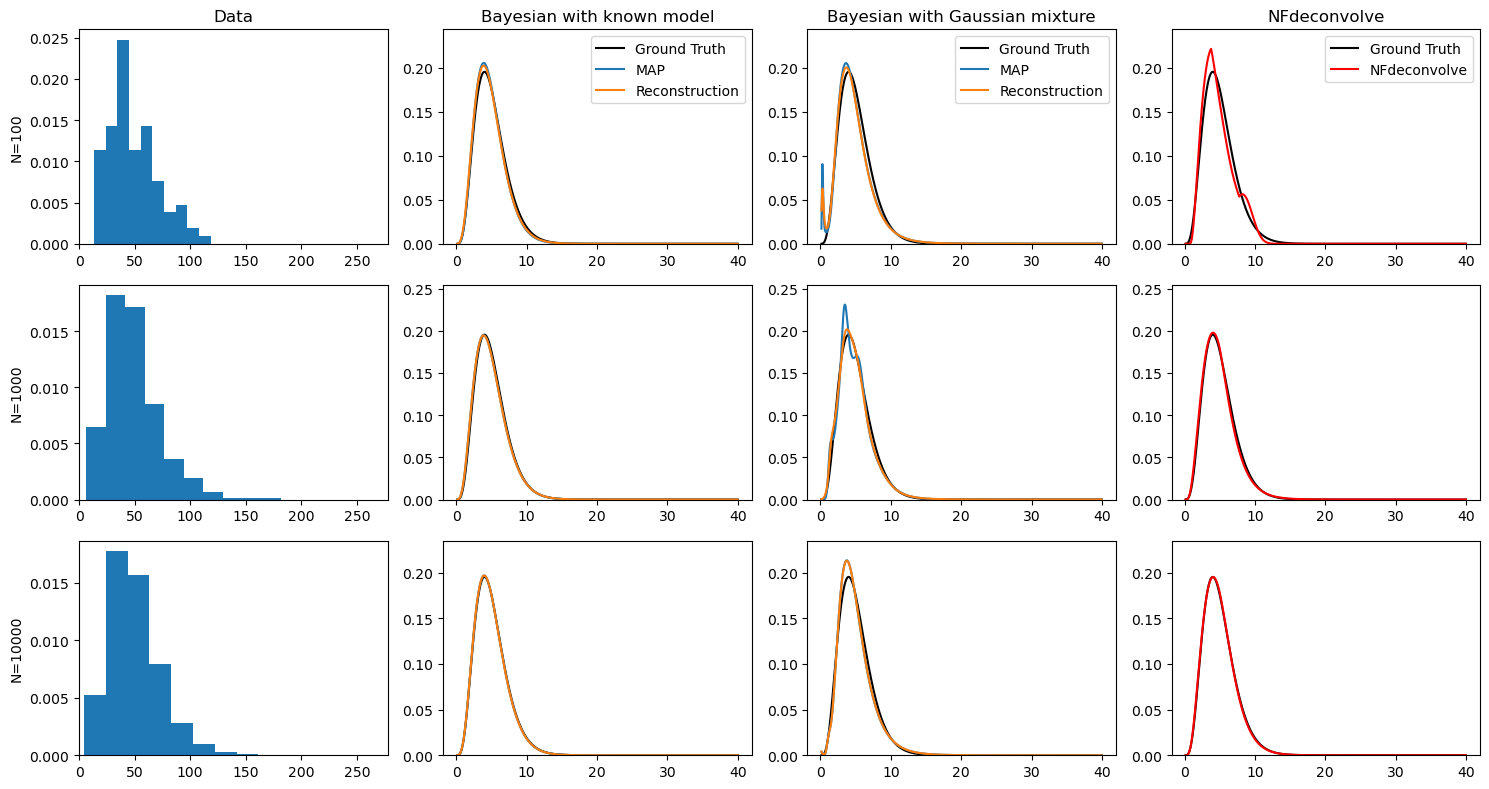

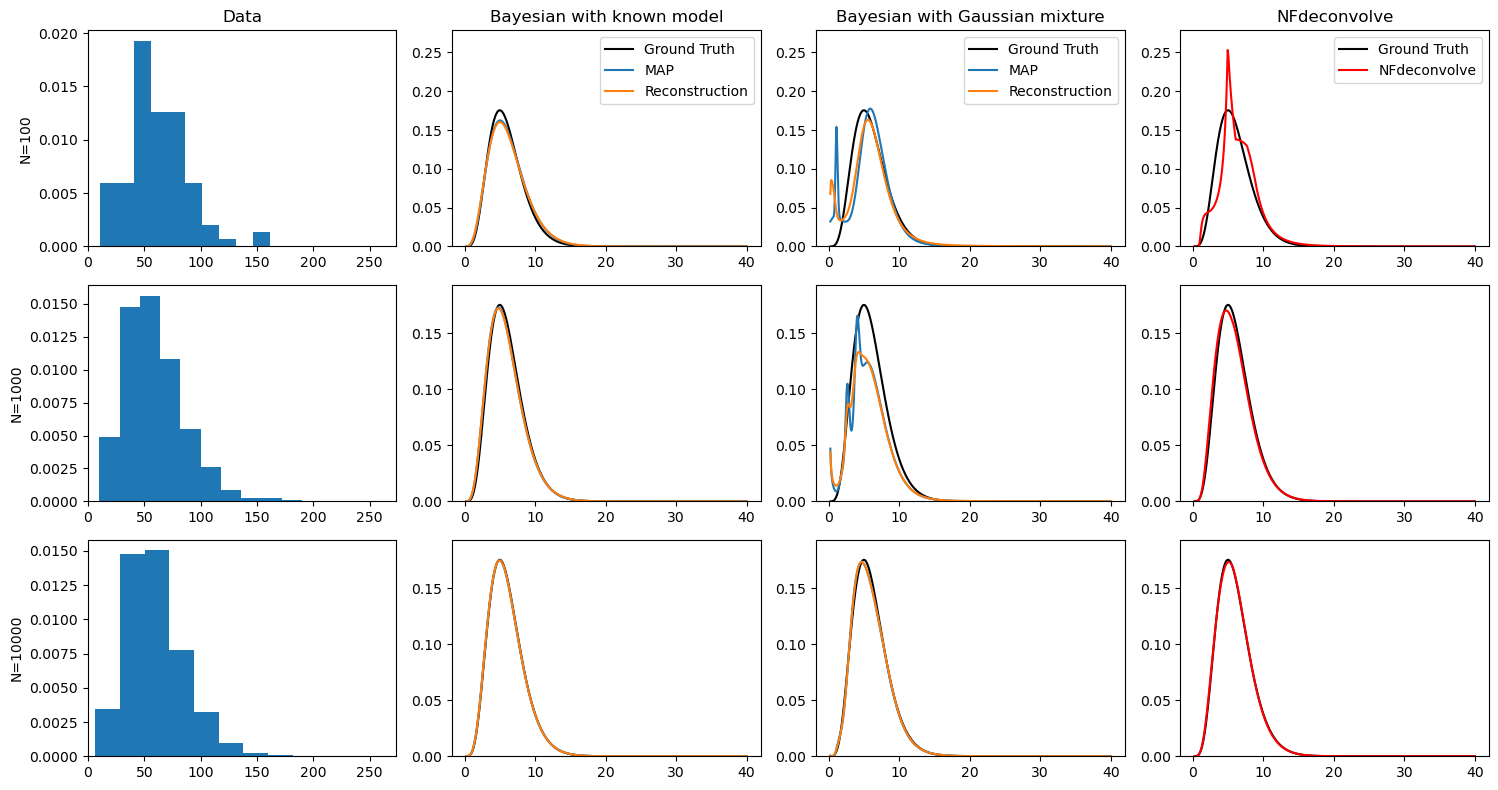

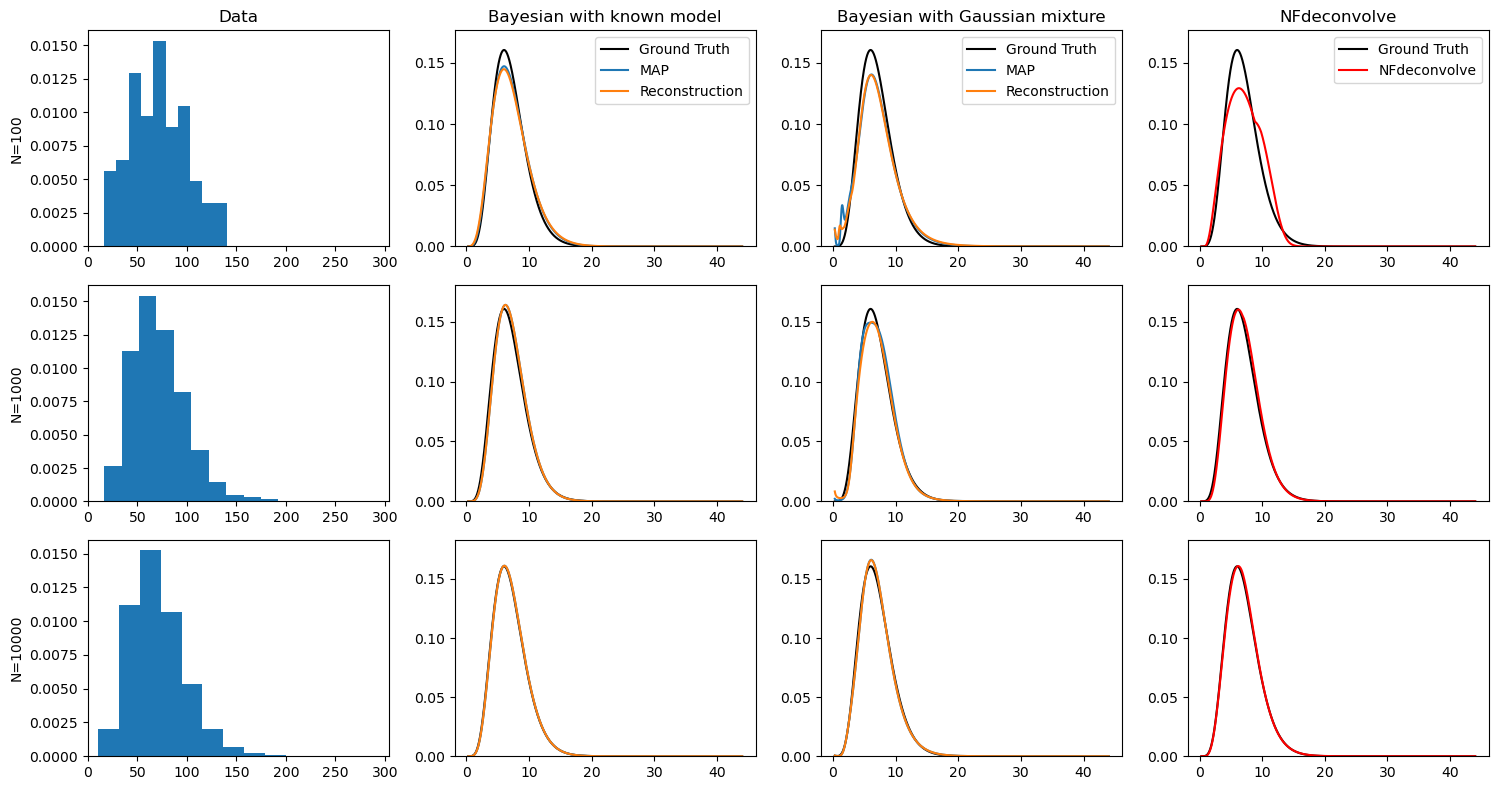

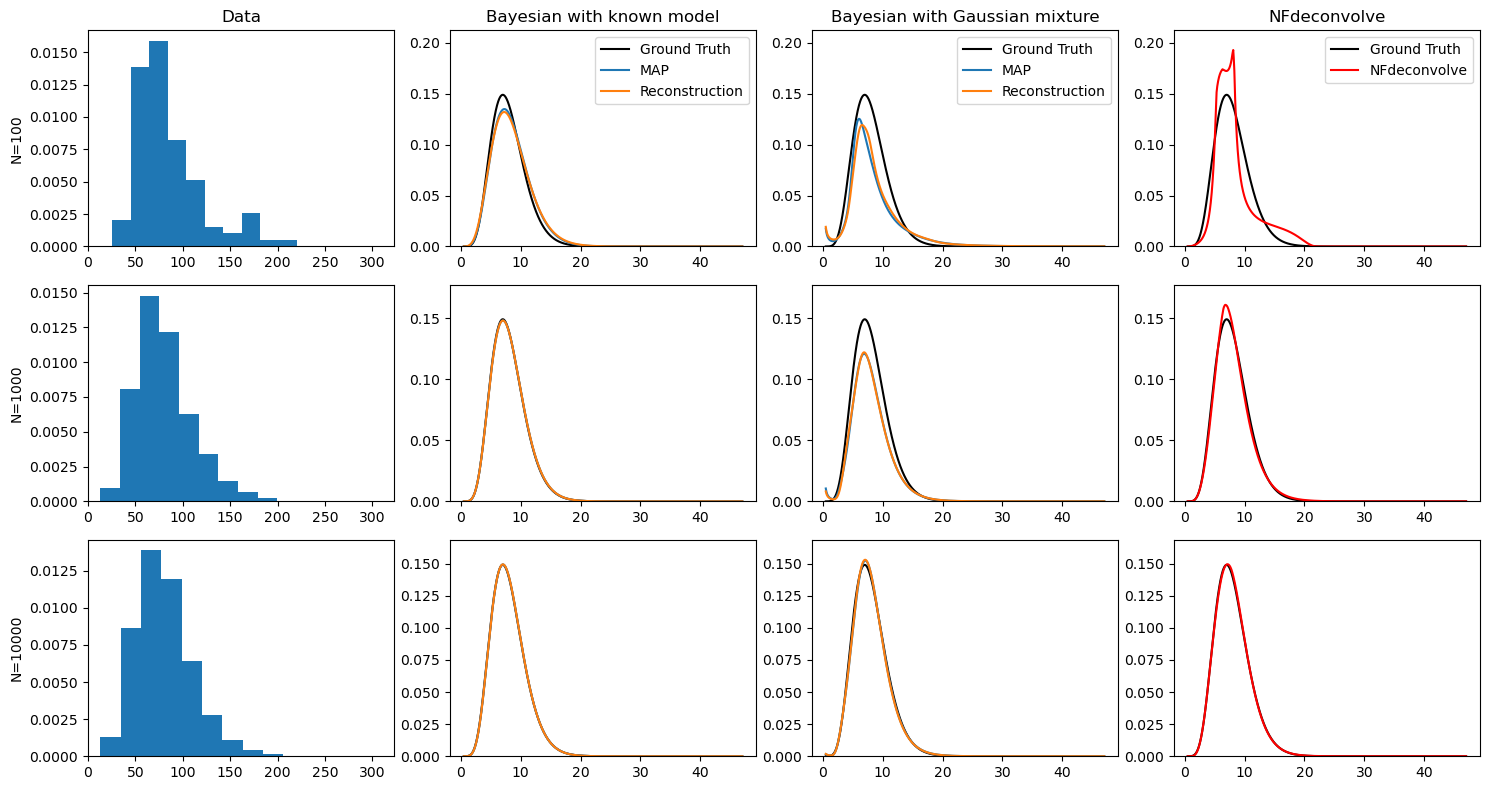

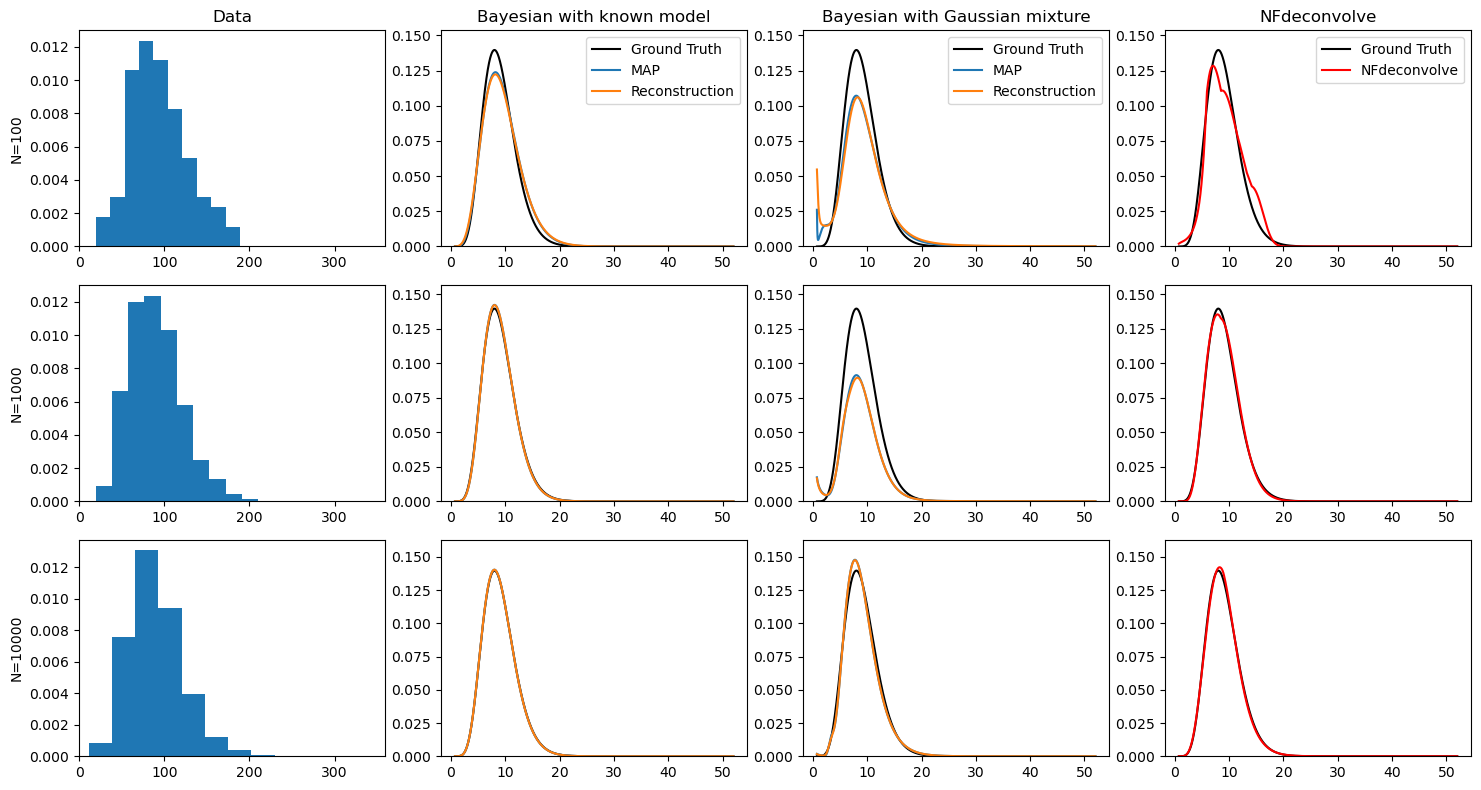

In [3]:
##MAIN sum examples

mu_a,sig_a = 10,1
df_sum = pd.DataFrame(columns=dfcolumns)

for shape in range(3,10):
    shape_gt,scale_gt = shape,1
    filename = 'N_{}_{}_G_{}_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt)
    a_distribution= torch.distributions.Normal(torch.tensor(mu_a).float(),torch.tensor(sig_a).float())

    fig,ax = plt.subplots(3,4,figsize=(15,8))
    for N,plot_row in zip(Ns,[0,None,1,None,2]):
        x = torch.tensor(loadtxt('datasets/'+filename)[:N]).float()
        xb = torch.linspace((x.min().item()-(mu_a+3*sig_a)),
                            (x.max().item()-(mu_a-3*sig_a)),10000)
        
        
        p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape_gt),torch.tensor(scale_gt)))
        p_nf = prob_nf(xb,filename,N,met='sum')
        bayes_map,bayes_rec = prob_bayes(xb,filename,N,met='sum')
        npbayes_map,npbayes_rec = prob_npbayes(xb,filename,N,met='sum')
  
        df_sum = pd.concat((df_sum,
                                df_line(filename,'Bayes',N,xb,p_gt,bayes_map,bayes_rec),
                                df_line(filename,'NPBayes',N,xb,p_gt,npbayes_map,npbayes_rec),
                                df_line(filename,'NF',N,xb,p_gt,p_nf)),ignore_index=True)

        if isinstance(plot_row,int):
            make_graph(ax[plot_row],x,xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec,legend=(N==Ns[0]))
    df_sum.to_csv('report.csv',index=False)    
    [axi.set_title(col)  for (col,axi) in zip(plot_cols,ax[0])]
    plt.tight_layout()
    fig.savefig('graphs/sum_'+filename.split('.')[0]+'.png',dpi=500)
#input('wait')
df_sum.to_csv('report.csv',index=False)

##MAIN product examples

mu_a,sig_a = 10,1
df_prod = pd.DataFrame(columns=dfcolumns)

for shape in range(3,10):
    shape_gt,scale_gt = shape,1
    filename = 'N_{}_{}_G_{}_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt)
    a_distribution= torch.distributions.Normal(torch.tensor(mu_a).float(),torch.tensor(sig_a).float())

    fig,ax = plt.subplots(3,4,figsize=(15,8))
    for N,plot_row in zip(Ns,[0,None,1,None,2]):
        x = torch.tensor(loadtxt('datasets/'+'prod_'+filename)).float()
        xb = torch.linspace((x.min().item()/(mu_a+3*sig_a)),
                            ceil(x.max().item()/(mu_a-3*sig_a)),10000)
        
        
        p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape_gt),torch.tensor(scale_gt)))

        p_nf = prob_nf(xb,'prod_'+filename,N,met='prod')
        bayes_map,bayes_rec = prob_bayes(xb,'prod_'+filename,N,met='prod')
        npbayes_map,npbayes_rec = prob_npbayes(xb,'prod_'+filename,N,met='prod')
   
        df_prod = pd.concat((df_prod,
                                df_line(filename,'Bayes',N,xb,p_gt,bayes_map,bayes_rec),
                                df_line(filename,'NPBayes',N,xb,p_gt,npbayes_map,npbayes_rec),
                                df_line(filename,'NF',N,xb,p_gt,p_nf)
                                ),ignore_index=True)
        
        if isinstance(plot_row,int):
            make_graph(ax[plot_row],x[:N],xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec,legend=(N==Ns[0]))
        
    [axi.set_title(col) for (col,axi) in zip(plot_cols,ax[0])]
    [axi.set_xlim((0,x.max().item())) for axi in ax[:,0]]
    plt.tight_layout()
    plt.savefig('graphs/prod_'+filename.split('.')[0]+'.png',dpi=500)

df_prod.to_csv('report_prod.csv',index=False)

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [5]:
## Part 2

def filename2snr_sum(filename):
    v,mu_a,sig_a,v2,g_shape,g_scale,v3 = filename.replace('.','_').split('_')
    varb = (float(g_shape)*float(g_scale)**2)
    vara = (float(sig_a)**2)
    return varb/(vara)

def filename2snr_prod(filename):
    v,mu_a,sig_a,v2,g_shape,g_scale,v3 = filename.replace('.','_').split('_')
    varbnorm = 1/float(g_shape)
    varanorm = (float(sig_a)/float(mu_a))**2
    return varbnorm/varanorm

def make_table(df,method,value):
    return df[df['method']==method].pivot(index='N', columns='snr', values=value)

def make_plot(ax,df_img,label,norm):
    pix = ax.imshow(np.log10(df_img.to_numpy()),aspect='auto',norm=norm)

    #ax.set_xticklabels([str(a) for a in range(2,10)])  
    xticks = np.concatenate(([0],df_img.columns.to_numpy().round()))
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(['',r'$10^2$',r'$10^{2.5}$',r'$10^{3}$',r'$10^{3.5}$',r'$10^{4}$',''])

    
    ax.set_xlabel('SNR',fontsize=14)
    ax.set_ylabel('Datapoints',fontsize=14)
    ax.set_title(label,fontsize=14)
    return pix


def grid_figure(df,fname,title):
	mosaic = [['a','a','b','b'],
		      ['c','c','d','d'],
		      ['X','e','e','X']]
	fig = plt.figure(layout="constrained",figsize=(12,9))
	axs = fig.subplot_mosaic(mosaic, empty_sentinel='X')


	lvl = np.log10(df[['KL_MAP','KL_reconstruct']].to_numpy())
	levels = np.linspace(0, 1, 11)*(lvl.max()-lvl.min()) + lvl.min()
	norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

	df_img=make_table(df,'Bayes','KL_MAP')
	make_plot(axs['a'],df_img, r'Bayesian with known model MAP',norm)
	df_img=make_table(df,'Bayes','KL_reconstruct')
	make_plot(axs['b'],df_img, r'Bayesian with known model reconstruction',norm)
	df_img=make_table(df,'NPBayes','KL_MAP')
	make_plot(axs['c'],df_img, r'Bayesian with Gaussian mixture MAP',norm)
	df_img=make_table(df,'NPBayes','KL_reconstruct')
	make_plot(axs['d'],df_img, r'Bayesian with Gaussian mixture reconstruction',norm)
	df_img=make_table(df,'NF','KL_MAP')
	pix = make_plot(axs['e'],df_img, r'NFdeconvolve',norm)


	# Add a colorbar on the side with explicit ticks and labels
	cbar = fig.colorbar(pix, ax=list(axs.values()), orientation='vertical', fraction =.04,pad=0.04)
	cbar.set_label('Color Scale')

	# Set ticks and labels to match the levels
	cbar.set_ticklabels([f'{level:.2f}' for level in levels])

	fig.suptitle( r'$\log_{10}$ KL divergence - '+title, fontsize=20 )
	plt.savefig('graphs/'+fname,dpi=500)


/tmp/ipykernel_129917/2961078741.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/tmp/ipykernel_129917/2961078741.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',r'$10^2$',r'$10^{2.5}$',r'$10^{3}$',r'$10^{3.5}$',r'$10^{4}$',''])


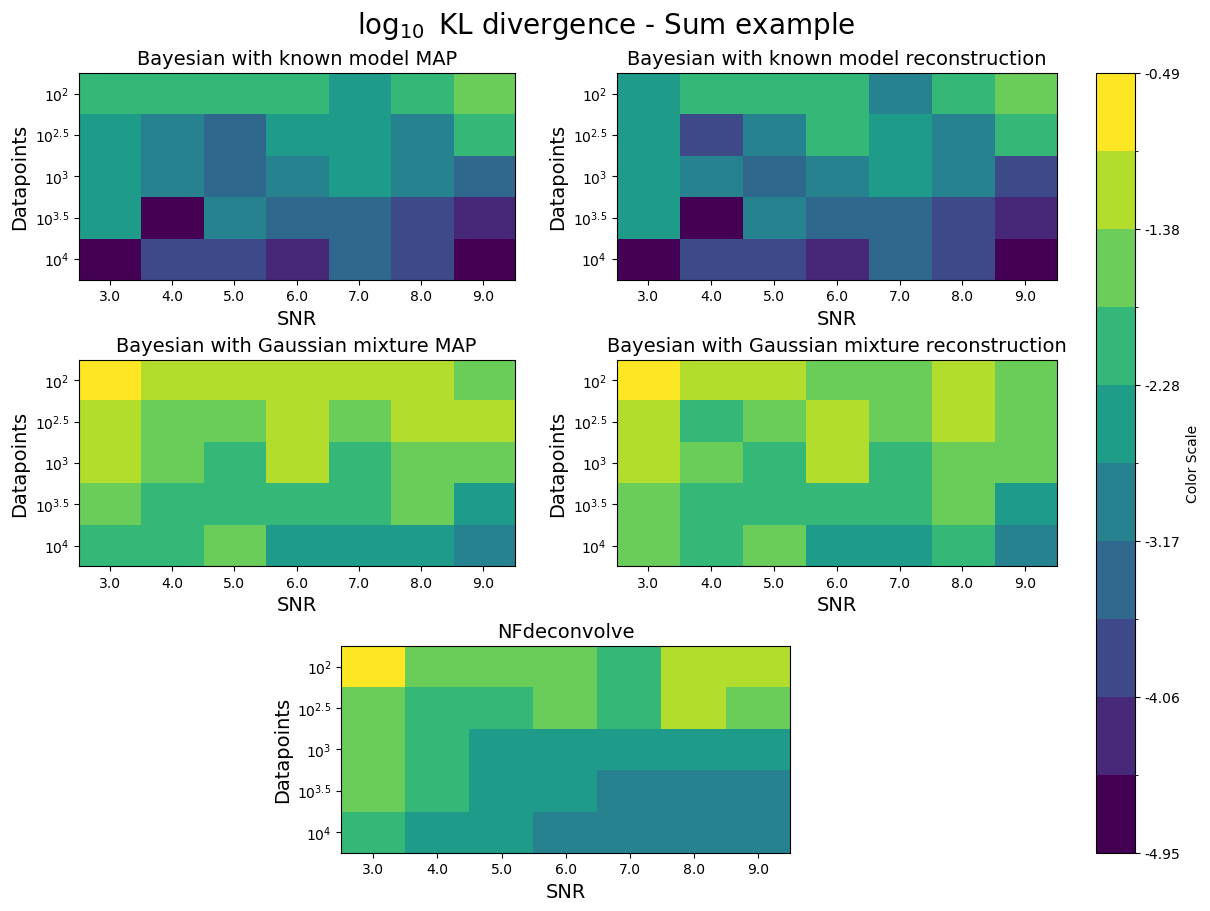

In [6]:
df = pd.read_csv('report.csv')
df['snr'] = [filename2snr_sum(fn) for fn in df['filename']]
grid_figure(df,'fig4.png', 'Sum example')

/tmp/ipykernel_129917/2961078741.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/tmp/ipykernel_129917/2961078741.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',r'$10^2$',r'$10^{2.5}$',r'$10^{3}$',r'$10^{3.5}$',r'$10^{4}$',''])


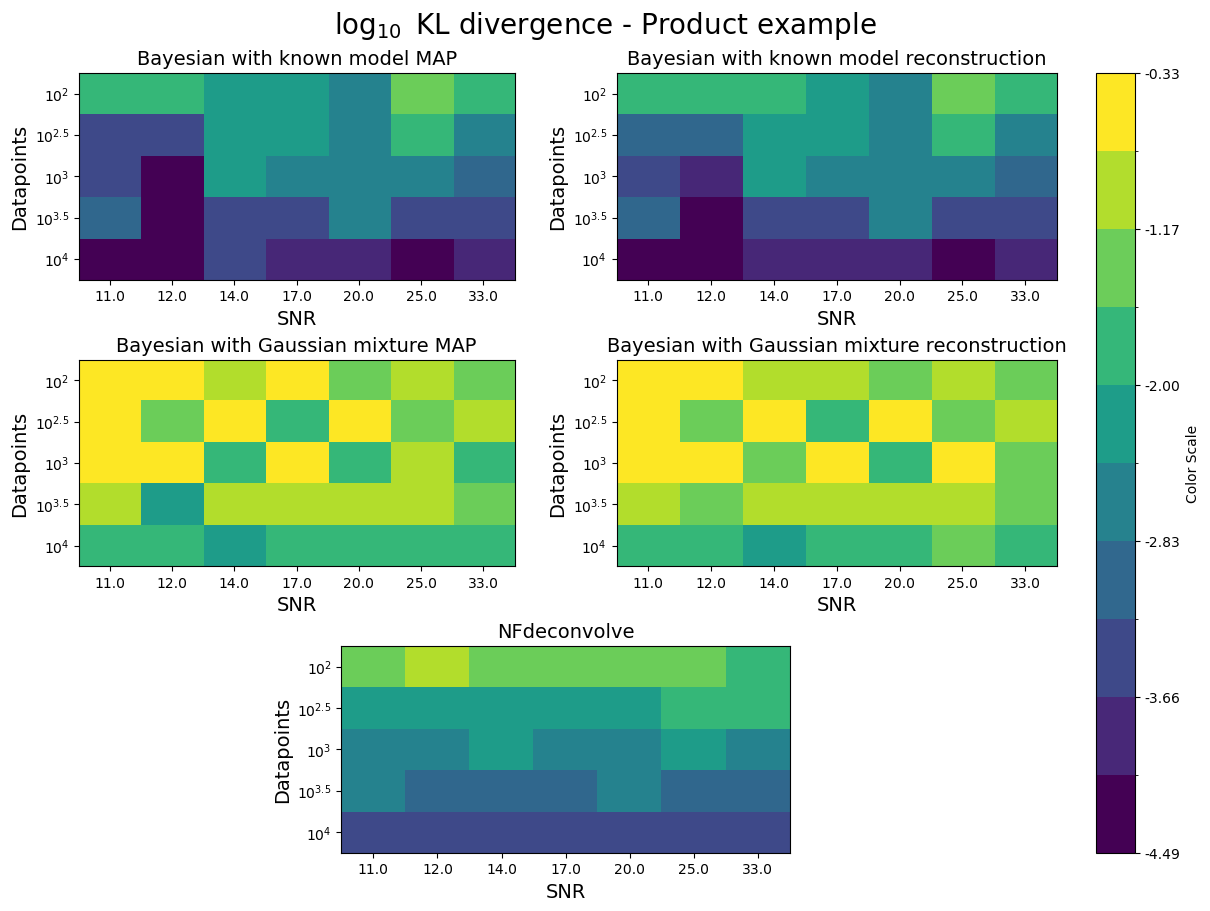

In [7]:
df = pd.read_csv('report_prod.csv')
df['snr'] = [filename2snr_prod(fn) for fn in df['filename']]
grid_figure(df,'fig5.png','Product example')